#### About

SOTA is between 88% - 90%: https://github.com/stratospark/food-101-keras


#### Load libraries

In [1]:
import fastai
from fastai.vision import *

In [2]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split('|')[0])

fastai: 1.0.43.post1
pytorch: 1.0.0
python: 3.6.5 


#### Examine dataset

In [8]:
# download the dataset
! cd /home/ubuntu/.fastai/data; wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# uncompress the data
! cd /home/ubuntu/.fastai/data; tar xf food-101.tar.gz

--2019-02-14 00:35:19--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-02-14 00:35:20--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  12.6MB/s    in 6m 17s  

2019-02-14 00:41:38 (12.6 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [3]:
path=Path('/home/ubuntu/.fastai/data/food-101')

In [4]:
# see what files we've got
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/food-101/images'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/meta'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/license_agreement.txt'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/test.csv'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/README.txt'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/train.csv')]

In [5]:
Path(path/'images').ls()[:5]

[PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/clam_chowder'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/cheesecake'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/gnocchi'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/escargots')]

In [6]:
# show some sample paths to the images
get_image_files(path/'images/foie_gras')[:5]

[PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/347577.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/1146464.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/2944644.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/1981572.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/2325009.jpg')]

torch.Size([3, 382, 512])


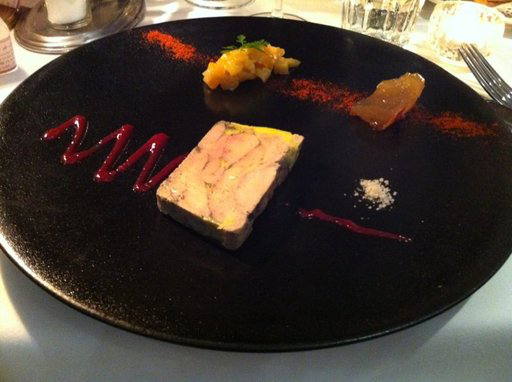

In [7]:
# look the shape and visualize one image
img = open_image(get_image_files(path/'images/foie_gras')[0])
print(img.shape)
img

In [8]:
# see how much data there is in some of the dirs
print('foie_gras: ', len(os.listdir(path/'images/foie_gras')))
print('gnocchi:', len(os.listdir(path/'images/gnocchi')))

foie_gras:  1000
gnocchi: 1000


Calcuate some stats about the image sizes.

In [10]:
# calculate average, minimum, and maximum for width and height of images
widths, heights = [], []
width_min, width_max = np.inf, -np.inf
height_min, height_max = np.inf, -np.inf

for dirname in os.listdir(path/'images'):
    for filename in os.listdir(path/'images'/dirname):
        image = PIL.Image.open(os.path.join(path/'images'/dirname, filename))
        widths.append(image.size[0])
        heights.append(image.size[1])

print('avg (width, height): ', (np.mean(widths), np.mean(heights)))
print('std (width, height): ', (np.std(widths), np.std(heights)))
print('width (min, max): ', (np.min(widths), np.max(widths)))
print('height (min, max): ', (np.min(heights), np.max(heights)))

avg (width, height):  (495.79139603960397, 475.3721287128713)
std (width, height):  (45.67412139905732, 65.30544596506714)
width (min, max):  (193, 512)
height (min, max):  (122, 512)


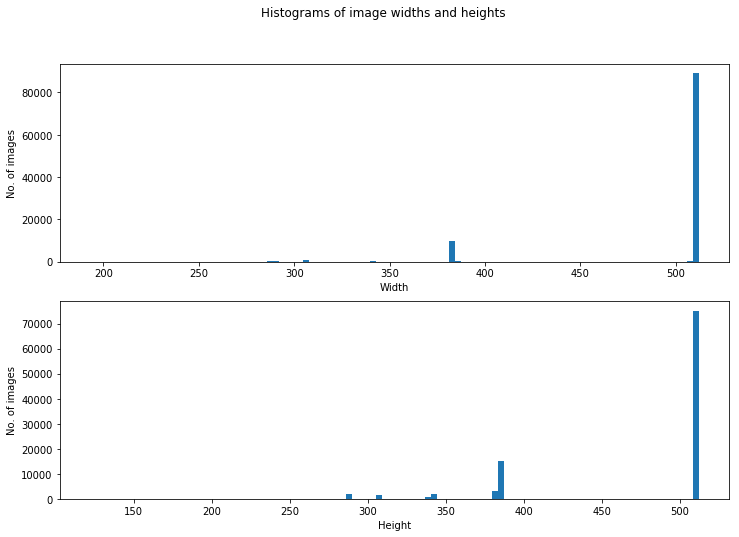

In [11]:
# plot histograms of heights and widths.
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of image widths and heights')
 
ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')
 
plt.show()

Generate csv files to use in datablock

In [12]:
out_file = open(path/'images/test.csv', 'a')
with open(path/'meta/test.txt') as f:
  for line in f:
    parts = line.split('/')
    line_out = line.strip('\n') + ',' + parts[0] + '\n'
    out_file.write(line_out)
out_file.close()

out_file = open(path/'images/train.csv', 'a')
with open(path/'meta/train.txt') as f:
  for line in f:
    parts = line.split('/')
    line_out = line.strip('\n') + ',' + parts[0] + '\n'
    out_file.write(line_out)
out_file.close()

#### Create datablock

In [13]:
# set hyperparamters
np.random.seed(42)
size = 299
bs = 64
num_workers = 4

In [14]:
data = ImageDataBunch.from_csv(path, folder='images', csv_labels='train.csv',
                               fn_col=0, label_col=1, suffix='.jpg',
                               size=size, bs=bs, num_workers=num_workers,
                               ds_tfms=get_transforms()).normalize(imagenet_stats)

#### Do sanity checks

In [15]:
# verify datasets loaded properly
print(len(data.train_ds))
print(len(data.valid_ds))

60600
15149


In [16]:
data.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

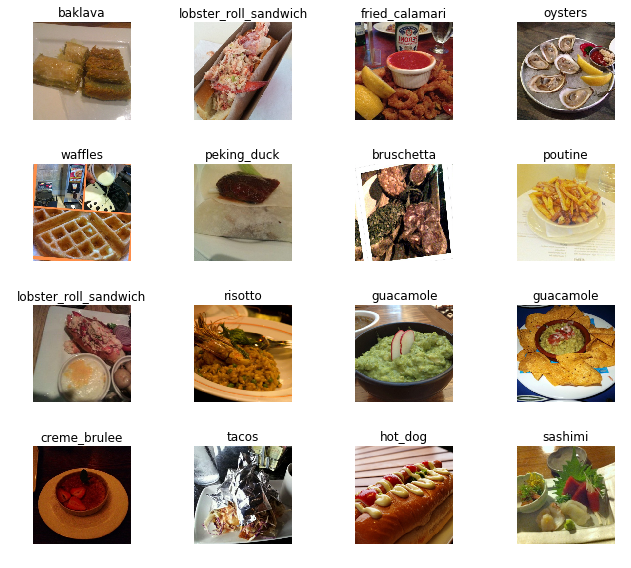

In [20]:
data.show_batch(rows=4, figsize=(9,8))

#### Create model

In [21]:
# define architecture
arch = models.resnet50

In [22]:
# create learner
learn = create_cnn(data, arch, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


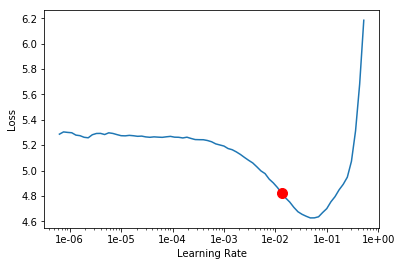

In [23]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 1.32e-2

#### Train on frozen model

In [ ]:
# first fit the head of the model
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy


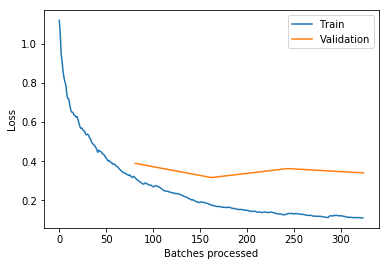

In [45]:
learn.recorder.plot_losses()

In [46]:
learn.save('stage-1')

#### Train on unfrozen model

In [47]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06


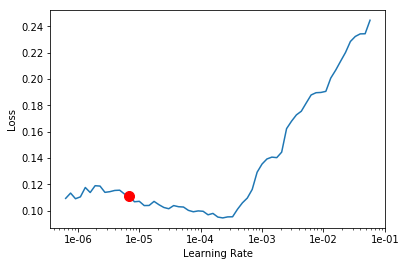

In [48]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [49]:
# now fit across the entire model
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.092072,0.335110,0.879808
2,0.090314,0.326181,0.891026


In [50]:
learn.save('stage-2')

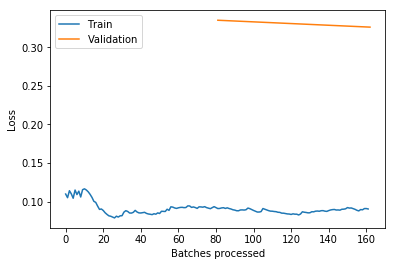

In [51]:
learn.recorder.plot_losses()

#### Look at results

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

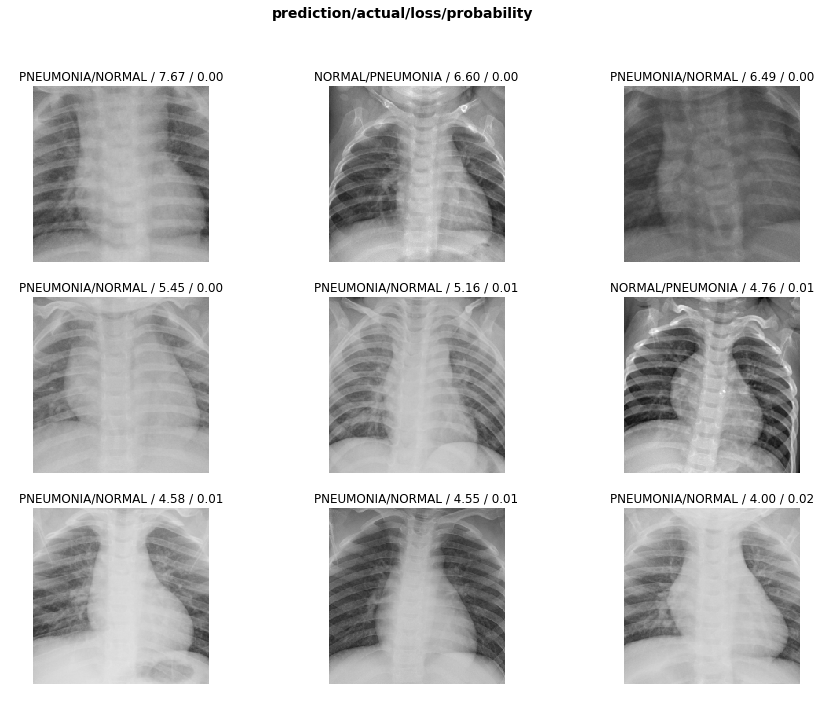

In [53]:
interp.plot_top_losses(9, figsize=(15,11))

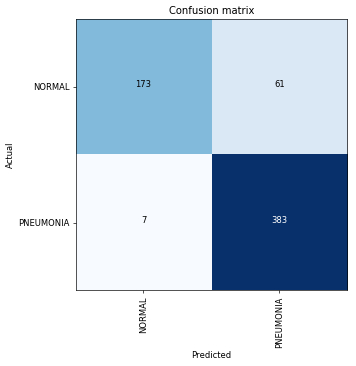

In [54]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [55]:
interp.most_confused(min_val=2)

[('NORMAL', 'PNEUMONIA', 61), ('PNEUMONIA', 'NORMAL', 7)]

Calculate precision and recall.
* Precision is a measure of how often we were correct out of all the times we predicted pneumonia.  The error here is cases that were fine that we thought were pneumonia.
* Recall is a measure of how often we correctly predicted pneumonia out of all the actual pneumonia cases.  The error here is actual pneumonia cases that we failed to detect.  For these types of medical applications its probably better to optimize for this number.

In [56]:
(tn, fp), (fn, tp) = interp.confusion_matrix()

In [57]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [58]:
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))

Precision: 0.86
Recall: 0.98
